In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from __future__ import print_function

import os
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from deepviz.guided_backprop import GuidedBackprop
# from sklearn.cross_validation import train_test_split
from sklearn.metrics.ranking import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import tensorflow as tf
from deepviz.guided_backprop import GuidedBackprop

try:
    import keras
    from imblearn.keras import balanced_batch_generator
    from imblearn.under_sampling import NearMiss
    import keras.backend as K
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation
    from keras.optimizers import RMSprop
    from keras.optimizers import Adam
    from keras.optimizers import Adagrad
    from keras.optimizers import SGD
    from keras.callbacks import LambdaCallback, ReduceLROnPlateau, ModelCheckpoint
    from keras.layers.core import Lambda
    from keras.losses import categorical_crossentropy
    from keras import regularizers

except:
    print("Keras not found")
    
np.random.seed(42)


def my_basename(path):
    return os.path.splitext(os.path.split(path)[1])[0]

file_dir=r'C:/Users/Mark.Rademaker/PycharmProjects/InternshipNaturalis/trait-geo-diverse-dl/data_GIS_extended'

Using TensorFlow backend.


In [3]:
#access file with list of taxa names
taxa=pd.read_csv(file_dir+"/data/SQL_filtered_gbif/taxa_list.txt",header=None)
taxa.columns=["taxon"] 

In [ ]:
#create text file to store results in and close again:
with open(file_dir+'/results/_DNN_performance/DNN_eval.txt','w+') as file:
    file.write("Species"+"\t"+"Test_loss"+"\t"+"Test_acc"+"\t"+"Test_tpr"+"\t"+"Test_AUC"+"\t"+"Test_LCI95%"+"\t"+"Test_UCI95%"+"\t"+"occ_samples"+"\t"+"abs_samples"+"\n")
    file.close()

In [4]:
###column variable names
with open(file_dir+'/data/GIS/env_stacked/variable_list.txt') as f:
      new_cols = f.readlines()

var_names=[]
for item in new_cols:
    item=item.replace("\n","")
    var_names.append(item) 
len(var_names)

181

In [6]:
%%capture
for species in taxa["taxon"][107:]:
    #try:
    print(species)
    spec = species
    variables=var_names.copy()
    variables.remove("%s_presence_map"%spec) #drop species own occurrences from input file

    #prepare dataframe for training, include weight for presence obserevations and readd col names
    table = pd.read_csv(file_dir +"/data/spec_ppa_env/%s_env_dataframe.csv"%spec)
    table=  table.drop('%s_presence_map'%spec,axis=1)
    #table.head()


    # print(len(table.index))
    table = table.dropna(axis=0, how="any")


    # make feature vector
    band_columns = [column for column in table.columns[1:181]]
   
    X = []
    y = []

    for _, row in table.iterrows():
        x = row[band_columns].values
        x = x.tolist()
        x.append(row["present/pseudo_absent"])
        X.append(x)

    df = pd.DataFrame(data=X, columns=band_columns + ["presence"])
    #df.head()
    df.to_csv("filtered.csv", index=None)

    ###########################################
    occ_len=int(len(df[df["presence" ]==1]))
    #print(occ_len)
    abs_len=int(len(df[df["presence" ]==0]))
    #print(abs_len)
    ############################################

    X = []
    y = []

    band_columns = [column for column in df.columns[:-1]]
    #print(band_columns)
    
    for _, row in df.iterrows():
        X.append(row[band_columns].values.tolist())
        y.append([1 - row["presence"], row["presence"]])

    X = np.vstack(X)
    #print(X)
    #print(type(X))
    print(X.shape)
    y = np.vstack(y)

    ######################### The actual model#####################
    #########################                 #####################
    #########################                 #####################
    test_loss=[]
    test_acc=[]
    test_AUC=[]
    test_tpr=[]
    test_uci=[]
    test_lci=[]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y,random_state=42)

    ####################
    test_set=pd.DataFrame(X_test)
    test_set.rename(columns=dict(zip(test_set.columns[0:180], variables)),inplace=True)
    
    shuffled_X_train=X_train.copy()
    np.random.shuffle(shuffled_X_train)
    shuffled_X_train=shuffled_X_train[:1000]

    shuffled_X_test=X_test.copy()
    np.random.shuffle(shuffled_X_test)
    shuffled_X_test=shuffled_X_test[:1000]

    ####################
    Best_model_AUC=[0]
    ####################
    for i in range(1,6):
        print("run %s"%i)

        batch_size = 75
        num_classes = 2
        epochs = 250

        num_inputs = X.shape[1]  # number of features


        model = Sequential()
        layer_1 = Dense(250, activation='relu',input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l2(0.000001))
        layer_2 = Dense(200, activation='relu', input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l2(0.000001))
        layer_3 = Dense(150, activation='relu', input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l2(0.0000001))
        layer_4 = Dense(100, activation='relu', input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l2(0.00000001))
        #layer_5 = Dense(150, activation='relu', input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l1(0.000001))
        #layer_6 = Dense(125, activation='relu', input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l1(0.0000001))
        #layer_7 = Dense(100, activation='relu', input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l1(0.0000001))
        
        model.add(layer_1)
        model.add(Dropout(0.3))
        model.add(layer_2)
        model.add(Dropout(0.5))
        model.add(layer_3)
        model.add(Dropout(0.3))
        model.add(layer_4)
        model.add(Dropout(0.5))
        #model.add(layer_5)
        #model.add(Dropout(0.1))
        #model.add(layer_6)
        #model.add(Dropout(0.2))
        #model.add(layer_7)

        out_layer = Dense(num_classes, activation=None)
        model.add(out_layer)
        model.add(Activation("softmax"))

        model.summary()

        model.compile(loss="categorical_crossentropy",
                    # optimizer =SGD(lr=0.001, momentum =0.9, nesterov=True),
                    # optimizer=Adagrad(lr=0.001),
                    # optimizer=RMSprop(lr=0.001),# rho=0.9, epsilon=1e-08, decay=0.0),
                    optimizer=Adam(lr=0.001),#, rho=0.9, epsilon=1e-08, decay=0.0),
                    metrics =['accuracy'])
        training_generator,steps_per_epoch = balanced_batch_generator(X_train, y_train, sampler=NearMiss(), batch_size=75, random_state=42)
        history = model.fit_generator(generator=training_generator, steps_per_epoch=steps_per_epoch, epochs=125, verbose=0)

        score = model.evaluate(X_test, y_test, verbose=0)
        #print('Test loss:', score[0])
        #print('Test accuracy:', score[1])
        predictions = model.predict(X_test)
       # print("AUC", roc_auc_score(y_test[:, 1], predictions[:, 1]))
        fpr, tpr, thresholds = roc_curve(y_test[:, 1], predictions[:, 1])
        len_tpr=int(len(tpr)/2)
       # print(len_tpr)
       # print("true positive rate", tpr[len_tpr])
        #plt.plot(fpr, tpr)
        #plt.show()


        test_loss.append(score[0])
        test_acc.append(score[1])
        test_AUC.append(roc_auc_score(y_test[:, 1], predictions[:, 1]))
        test_tpr.append(tpr[len_tpr])
        AUC = roc_auc_score(y_test[:, 1], predictions[:, 1])

        ###confidence intervals#######################
        ##############################################
        n_bootstraps=1000
        y_pred=predictions[:,1]
        y_true=y_test[:,1]
        rng_seed=42
        bootstrapped_scores =[]


        rng=np.random.RandomState(rng_seed)
        
        for i in range (n_bootstraps):
            #bootstrap by sampling with replacement on prediction indices
            indices = rng.randint(0,len(y_pred)-1,len(y_pred))
            if len (np.unique(y_true[indices])) <2:
                continue

            score = roc_auc_score(y_true[indices],y_pred[indices])
            bootstrapped_scores.append(score)

        sorted_scores=np.array(bootstrapped_scores)
        sorted_scores.sort()

        ci_lower=sorted_scores[int(0.05*len(sorted_scores))]
        ci_upper=sorted_scores[int(0.95*len(sorted_scores))]
       # print("CI for the score: [{:0.3f}-{:0.3f}]".format(ci_lower,ci_upper))

        test_lci.append(ci_lower)
        test_uci.append(ci_upper)
        ####################################################
        ####################################################


        #determine whether new model AUC is higher
        if AUC > Best_model_AUC[0]:
            # if yes save model to disk / overwrite previous model
            Best_model_AUC[0]=AUC
            model_json=model.to_json()
            with open (file_dir+'/results/{}/{}_model.json'.format(spec,spec),'w') as json_file:
                json_file.write(model_json)
            model.save_weights(file_dir+'/results/{}/{}_model.h5'.format(spec,spec))
            #if yes, save a figure of shap feature value impact    

            if int(len(X_train)) > 5000:           
                explainer=shap.DeepExplainer(model,shuffled_X_train)
                test_set=pd.DataFrame(shuffled_X_test)
                test_set.rename(columns=dict(zip(test_set.columns[0:180], variables)),inplace=True)

                shap_values=explainer.shap_values(shuffled_X_test)
                fig=shap.summary_plot(shap_values[1],test_set,show=False)
                plt.savefig(file_dir+'/results/{}/{}_feature_impact'.format(spec,spec),bbox_inches="tight")
                plt.close()

            else:
                explainer=shap.DeepExplainer(model,X_train)
                shap_values=explainer.shap_values(X_test)
                fig=shap.summary_plot(shap_values[1],test_set,show=False)
                plt.savefig(file_dir+'/results/{}/{}_feature_impact'.format(spec,spec),bbox_inches="tight")
                plt.close()
            #print('saved model to disk')


    ####################
    avg_loss= sum(test_loss)/len(test_loss)
    avg_acc = sum(test_acc)/len(test_acc)
    avg_AUC = sum(test_AUC)/len(test_AUC)
    avg_tpr = sum(test_tpr)/len(test_tpr)
    avg_lci = sum(test_lci)/len(test_lci)
    avg_uci = sum(test_uci)/len(test_uci)


    with open(file_dir+'/results/_DNN_performance/DNN_eval.txt','a') as file:
        file.write(spec+"\t"+str(avg_loss)+"\t"+str(avg_acc)+"\t"+str(avg_tpr)+"\t"+str(avg_AUC)+"\t"+str(avg_lci)+"\t"+str(avg_uci)+"\t"+str(occ_len)+"\t"+str(abs_len)+"\n")       



#except:
 #       pass

    


3305

3307

106

3307

3307

3307

136

3307

3312

143

3312

3316

3316

139

3316

143

3316

3316

134

3316

3316

3316

142

3316

3316

127

3316

3316

147

3316

3316

3316

127

3316

3316

136

3316

3316

145

3316

123

3316

3316

3316

146

3316

3316

3316

3316

123

3316

3316

3316

3316

110

3316

3316

139

create graphs for evaluating occurrence sample size on dnn performance

Text(0.5, 0, 'Log10 occurrence samples')

Text(0, 0.5, 'Test loss')

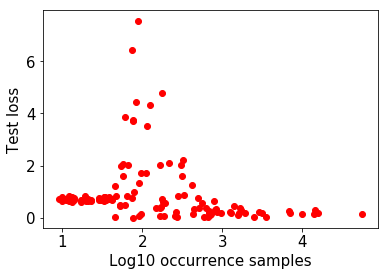

Text(0.5, 0, 'Log10 occurrence samples')

Text(0, 0.5, 'Test accuracy')

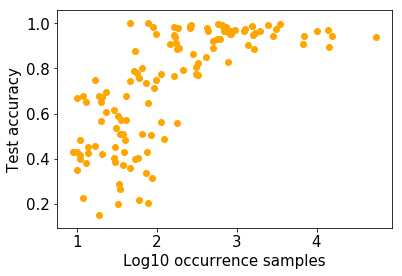

Text(0.5, 0, 'Log10 occurrence samples')

Text(0, 0.5, 'Test AUC')

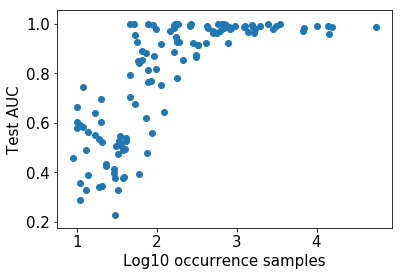

Text(0.5, 0, 'Log10 occurrence samples')

Text(0, 0.5, 'Confidence band width')

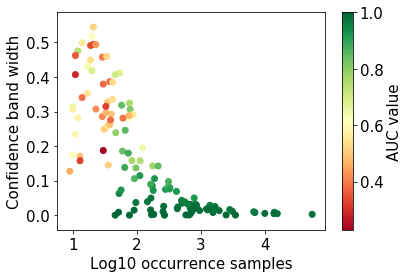

In [6]:
import math
data=pd.read_csv(file_dir+'/results/_DNN_performance/DNN_eval.txt',sep="\t")
plt.rcParams.update({'font.size': 15})

#data
x=data["occ_samples"]
x= [math.log10(i) for i in x]

y1=data["Test_loss"]
y2=data["Test_acc"]
#y3=data["Test_tpr"]
y4=data["Test_AUC"]
#n=data["Test_AUC"].round(3)
lci=data["Test_LCI95%"]
uci=data["Test_UCI95%"]
wci=data["Test_UCI95%"]-data["Test_LCI95%"]

fig = plt.figure()
plt.scatter(x,y1,c="red")
plt.xlabel("Log10 occurrence samples")
plt.ylabel("Test loss")
fig.savefig(file_dir+'/results/_DNN_performance/Test_loss.png', dpi=fig.dpi,bbox_inches="tight")
plt.show()

fig = plt.figure()
plt.scatter(x,y2,c="orange")
plt.xlabel("Log10 occurrence samples")
plt.ylabel("Test accuracy")
fig.savefig(file_dir+'/results/_DNN_performance/Test_acc.png', dpi=fig.dpi,bbox_inches='tight')
plt.show()

#fig = plt.figure()
#plt.scatter(x,y3,c="green")
#plt.xlabel("occurrence samples")
#plt.ylabel("Test_tpr")
#fig.savefig(file_dir+'/results/Test_acc.png', dpi=fig.dpi)
#plt.show()


fig = plt.figure()
plt.scatter(x,y4)
plt.xlabel("Log10 occurrence samples")
plt.ylabel("Test AUC")
fig.savefig(file_dir+'/results/_DNN_performance/Test_AUC.png', dpi=fig.dpi,bbox_inches='tight')
plt.show()

fig = plt.figure()
points=plt.scatter(x,wci,c=y4,cmap="RdYlGn")
cbar=plt.colorbar(points)
cbar.set_label("AUC value")
plt.xlabel("Log10 occurrence samples")
plt.ylabel("Confidence band width")
fig.savefig(file_dir+'/results/_DNN_performance/Confidence_width.png', dpi=fig.dpi,bbox_inches='tight')
plt.show()

#for i, txt in enumerate(n):
 #   plt.annotate(txt, (x[i], y[i]))

In [ ]:
 ###########################################
    ###########################################
##Guided backpropagation through model
guided_bprop = GuidedBackprop(model)
#mask = guided_bprop.get_mask(X_test[0])
masks = []
for i in range(X_test.shape[0]):
    masks.append(guided_bprop.get_mask(X_test[i]))
    #print(masks[-1].shape)
print(np.vstack(masks).shape)
mask = np.mean(np.vstack(masks), axis=0)
#show_image(mask)
print(band_columns[mask.argmax()])
print(np.array(band_columns)[mask.argsort()])
    ###########################################
    ###########################################

In [ ]:
#Backup train code
def main():
    table = pd.read_csv(file_dir +"/data/capriolus_trial/%s_env_dataframe.csv")
    table =table.loc[:1500]
    # at 40 degrees latitude
    bin_size_km = 5
    one_degree_latitude_km = 111.03  # http://www.longitudestore.com/how-big-is-one-gps-degree.html
    one_degree_longitude_km = 85.39
    step_latitude = 1. / one_degree_latitude_km * bin_size_km
    step_longitude = 1. / one_degree_longitude_km * bin_size_km
    # print("step_latitude, step_longitude", step_latitude, step_longitude)

    # remove spaces from column names
    for column in table.columns:
        table[column.strip()] = table[column]
        if column.strip() != column:
            del table[column]
    # print(table.columns)
    # print(table.decimal_latitude.min(), table.decimal_latitude.max())

    latitude_min = table.decimal_latitude.min()
    longitude_min = table.decimal_longitude.min()
    table.decimal_latitude = table.decimal_latitude.apply(lambda x: (x - latitude_min) // step_latitude)
    table.decimal_longitude = table.decimal_longitude.apply(lambda x: (x - longitude_min) // step_longitude)
    table.decimal_latitude = table.decimal_latitude.astype(int)
    table.decimal_longitude = table.decimal_longitude.astype(int)

    # make feature vector
    band_columns = [column for column in table.columns[8:]]
    X = []
    y = []
    for _, row in table.iterrows():
        x = row[band_columns].values
        if (np.any(x <= -9999.0)):  # in sea?
            continue
        # print(row["present/pseudo_absent"], np.where(x <= -9999.0)[0])
        x = x.tolist()
        x.append(row["present/pseudo_absent"])
        X.append(x)

    df = pd.DataFrame(data=X, columns=band_columns + ["presence"])
    df.to_csv("filtered.csv", index=None)

    print(len(df[df["presence" ]==1]))
    print(len(df[df["presence" ]==0]))

    # Scale feature values
    for column in df.columns[:-1]:
        # if "band" in column:
        std_dev = np.std(df[column])
        mean_ = np.mean(df[column])
        df[column] = df[column].apply(lambda x: (x - mean_) / std_dev)
    df.to_csv("normalized.csv", index=None)

    X = []
    y = []
    band_columns = [column for column in df.columns[:-1]]
    # print(band_columns)

    for _, row in df.iterrows():
        X.append(row[band_columns].values.tolist())
        y.append([1 - row["presence"], row["presence"]])

    X = np.vstack(X)
    y = np.vstack(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

    batch_size = 75
    num_classes = 2
    epochs = 125
    
    num_inputs = X.shape[1]  # number of features

    #reducelr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-8,
     #                                     verbose=1)
    
    model = Sequential()
    layer_1 = Dense(50, activation='relu',input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l1(0.000001))

    layer_2 = Dense(25, activation='relu', input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l1(0.000001))
    layer_3 = Dense(25, activation='relu', input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l1(0.0000001))
    layer_4 = Dense(25, activation='relu', input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l1(0.00000001))
    
    
    model.add(layer_1)
    model.add(Dropout(0.3))
    model.add(layer_2)
    model.add(Dropout(0.5))
    model.add(layer_3)
    model.add(Dropout(0.3))
    model.add(layer_4)
    model.add(Dropout(0.5))
  
    
    
    # model.add(Lambda(lambda x: K.dropout(x, level=0.5)))
    # model.add(Dense(512, activation='relu',
    #             # kernel_regularizer=regularizers.l2(0.01),
    #             # activity_regularizer=regularizers.l1(0.01)
    #                 ))
    # model.add(Dropout(0.5))
    # model.add(Lambda(lambda x: K.dropout(x, level=0.5)))
    out_layer = Dense(num_classes, activation=None)
    model.add(out_layer)
    model.add(Activation("softmax"))

    model.summary()

    model.compile(loss="categorical_crossentropy",
                # optimizer =SGD(lr=0.001, momentum =0.9, nesterov=True),
                # optimizer=Adagrad(lr=0.001),
                # optimizer=RMSprop(lr=0.001),# rho=0.9, epsilon=1e-08, decay=0.0),
                optimizer=Adam(lr=0.001),#, rho=0.9, epsilon=1e-08, decay=0.0),
                metrics =['accuracy'])

    history = model.fit(X_train, y_train,
    batch_size =batch_size,
    epochs =epochs,
    verbose =1,
    validation_data =(X_test, y_test),
    callbacks =[],
    shuffle =True,
    class_weight ={
        0: 1,
        1: 1,
    }
    )

    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    predictions = model.predict(X_test)
    print("AUC", roc_auc_score(y_test[:, 1], predictions[:, 1]))
    fpr, tpr, thresholds = roc_curve(y_test[:, 1], predictions[:, 1])
    plt.plot(fpr, tpr)
    plt.show()
    
    guided_bprop = GuidedBackprop(model)
    #mask = guided_bprop.get_mask(X_test[0])
    masks = []
    for i in range(X_test.shape[0]):
        masks.append(guided_bprop.get_mask(X_test[i]))
        #print(masks[-1].shape)
    print(np.vstack(masks).shape)
    mask = np.mean(np.vstack(masks), axis=0)
    show_image(mask)
    print(band_columns[mask.argmax()])
    print(np.array(band_columns)[mask.argsort()])
    
    for i, xy in enumerate(zip(fpr, tpr)):
        plt.gca().annotate(str(thresholds[i]), xy=xy, textcoords='data')

    plt.show()


if __name__ == "__main__":
    main()


